In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

csv_path = '../_shared/data/synthetic-v2/data.csv'
df = pd.read_csv(csv_path)

In [ ]:
# Get patients ids
patient_ids = df['PATIENT_ID'].unique()

In [ ]:
from datetime import datetime

df['VISIT_DATE'] = df.apply(lambda row: datetime.strptime(row['VISIT_DATE'], "%d-%m-%Y"), axis=1)

In [91]:
def create_state_machine(feature):
    in_episode = False
    episode = 0
    def step(row):
        nonlocal in_episode, episode
        if not in_episode and row[feature] == 0:
            return -1
        if not in_episode and row[feature] > 0:
            in_episode = True
            return episode
        if in_episode and row[feature] == 0:
            in_episode = False
            episode += 1
            return -1
        if in_episode and row[feature] > 0:
            return episode
    return step

def show_feature(feature):

    fig, axs = plt.subplots(1, 2, figsize=(14, 5))

    # Watch out this can contain outlier(s)
    for patient_id in patient_ids[::500]:

    # for patient_id in patient_ids:
        mask = df['PATIENT_ID'] == patient_id
        df_patient = df[mask].copy()

        # Number of pockets is leading in finding: Parodontitis
        next_step = create_state_machine('NR_OF_POCKET')

        df_patient['EPISODE'] = df_patient.apply(next_step, axis=1)
        episodes = df_patient['EPISODE'].unique()

        # Skip person(s) that are healthy
        if len(episodes) == 1: continue

        for episode in range(len(episodes)-1):
            episode_mask = df_patient['EPISODE'] == episode

            df_patient_episode = df_patient[episode_mask].copy().reset_index()

            shift = min(df_patient_episode['VISIT_DATE'])
            df_patient_episode['DAYS_SINCE_ONSET'] = df_patient_episode.apply(lambda row: (row['VISIT_DATE'] - shift).days, axis=1)

            axs[0].plot(df_patient_episode['DAYS_SINCE_ONSET'], df_patient_episode[feature])

            has_parodontitis_mask = df_patient_episode['HAS_PARODONTITIS'] == 1
            has_not_parodontitis_mask = df_patient_episode['HAS_PARODONTITIS'] != 1

            # Has not Pardontitis
            df_has_not_parodontitis = df_patient_episode[has_not_parodontitis_mask]
            if len(df_has_not_parodontitis) > 0:
                axs[0].scatter(df_has_not_parodontitis['DAYS_SINCE_ONSET'], df_has_not_parodontitis[feature], marker='.', label=f"{patient_id}-{episode}", alpha=0.7)

            # Has Pardontitis
            df_has_parodontitis = df_patient_episode[has_parodontitis_mask]
            if len(df_has_parodontitis) > 0:
                axs[0].scatter(df_has_parodontitis['DAYS_SINCE_ONSET'], df_has_parodontitis[feature], marker='x', label=f"{patient_id}-{episode}", alpha=0.7)

            # Enable legend for ax: 0
            # axs[0].legend()
            axs[0].set_ylabel(f'{feature}')
            axs[0].set_xlabel('DAYS')

            # Plot first values from onset
            axs[1].scatter(episode, df_patient_episode[feature][0], marker='o', label=f"{patient_id}-{episode}")
            # axs[1].hist(episode, df_patient_episode[feature][0], label=f"{patient_id}-{episode}")
            # Enable legend for ax: 1
            # axs[1].legend()
            axs[1].set_ylabel(f'{feature} ONSET')
            axs[1].set_xlabel('EPISODE(S)')

    plt.show()

feature: BLEEDING_ON_PROBING


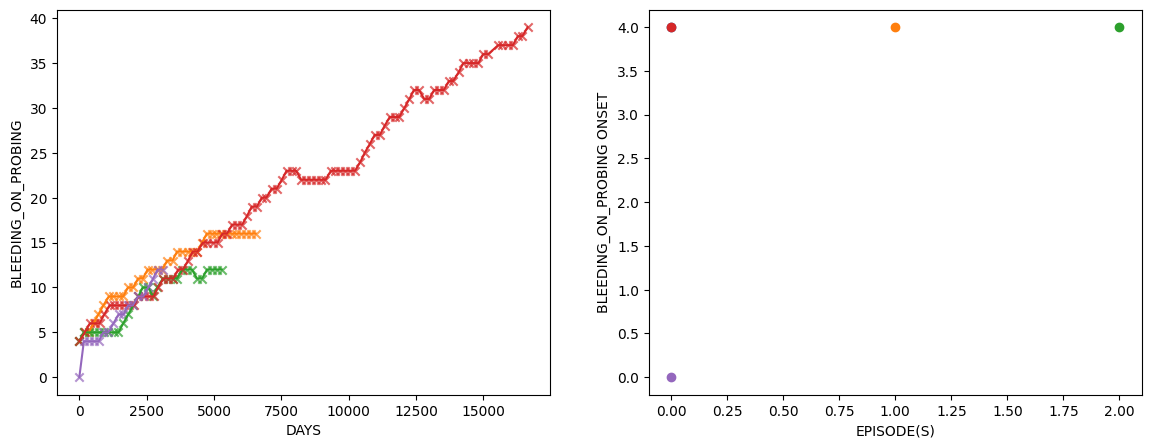

feature: NR_OF_POCKET


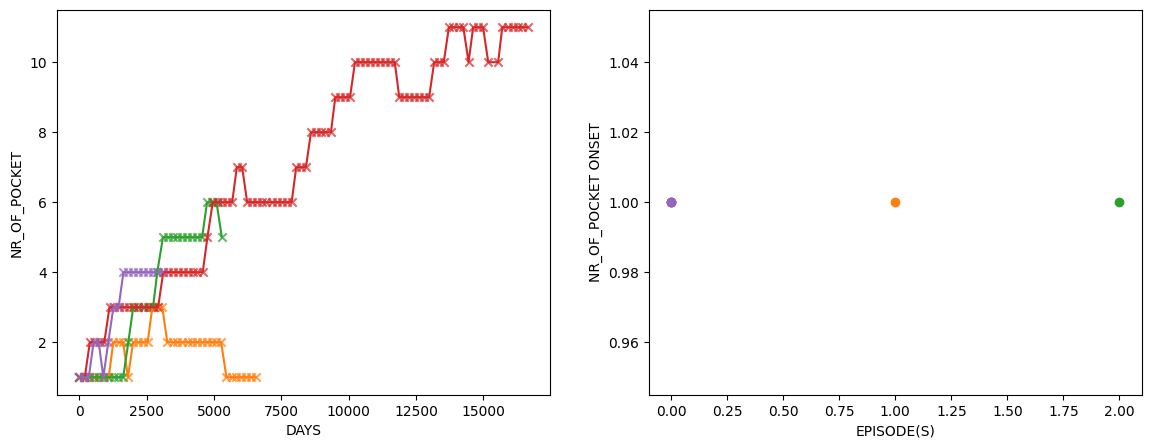

feature: TOTAL_LOSS_OF_ATTACHMENT_LEVEL


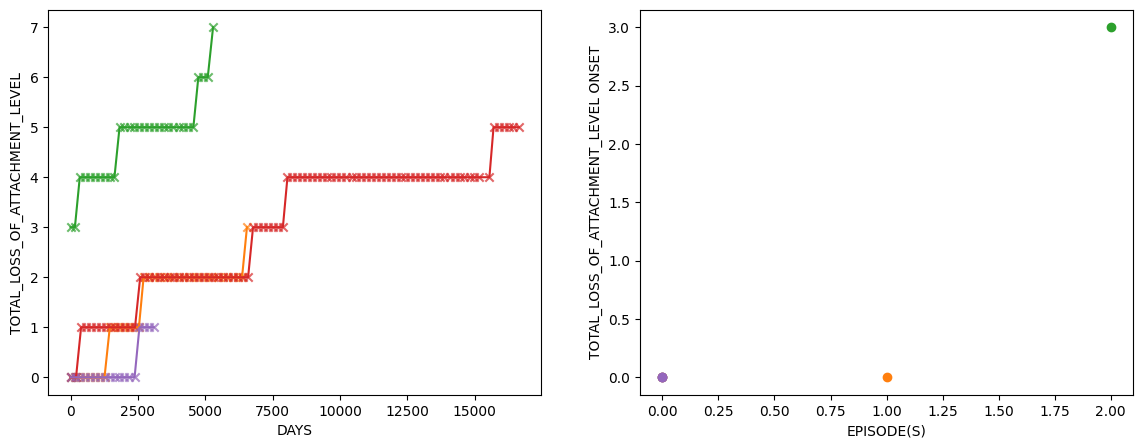

feature: NR_OF_FURCATION


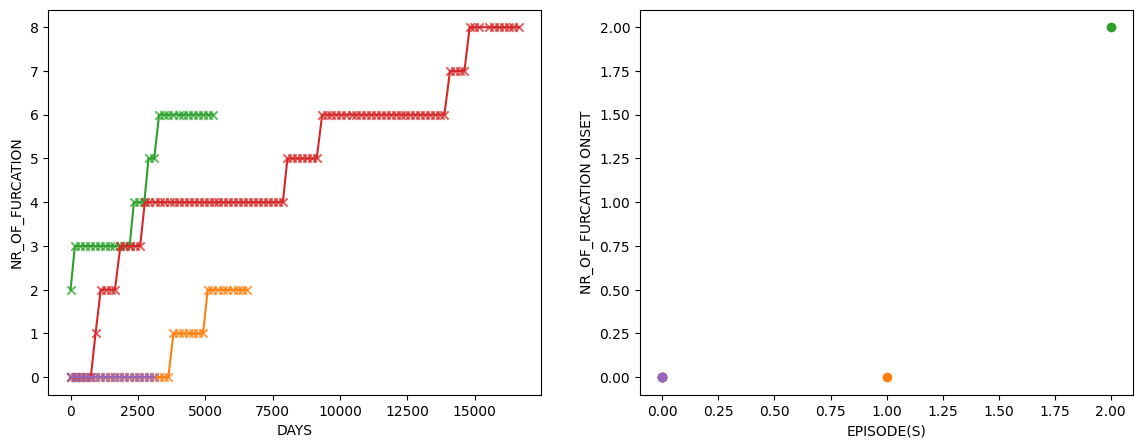

feature: NR_OF_MOBILITY


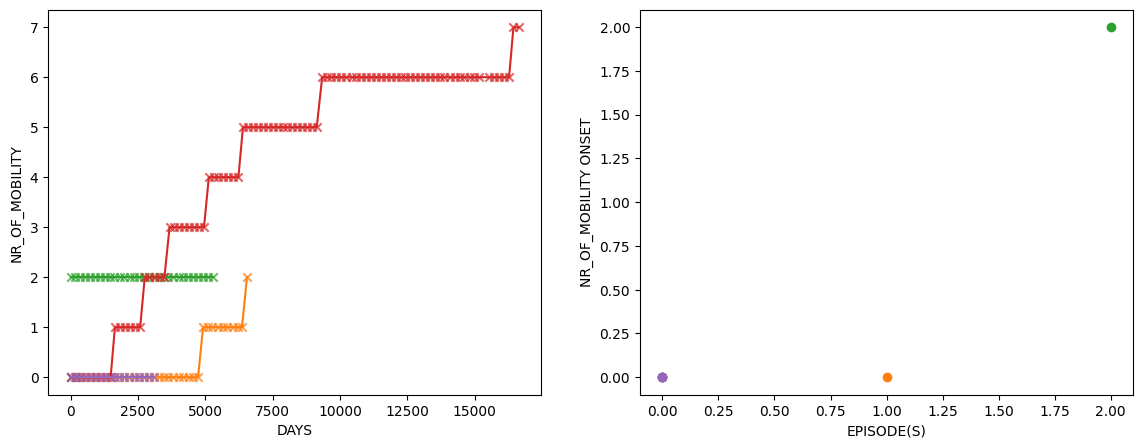

In [92]:
features = ['BLEEDING_ON_PROBING', 'NR_OF_POCKET', 'TOTAL_LOSS_OF_ATTACHMENT_LEVEL', 'NR_OF_FURCATION', 'NR_OF_MOBILITY']

for feature in features:
    print(f"feature: {feature}")
    show_feature(feature)